In [1]:
!pip install torch torchvision --quiet
!pip install sympy==1.13.1 --quiet


In [3]:
import os
import torch
from tqdm import tqdm
import torchvision
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torchvision.datasets import CIFAR100
import torchvision.transforms as tt
import torch.nn as nn
from tqdm import tqdm
import seaborn as sns



In [4]:
super_classes_dict = {
    'aquatic mammals': ['beaver', 'dolphin', 'otter', 'seal', 'whale'],
'fish': ['aquarium_fish', 'flatfish', 'ray', 'shark', 'trout'],
'flowers': ['orchid', 'poppy', 'rose', 'sunflower', 'tulip'],
'food containers': ['bottle', 'bowl', 'can', 'cup', 'plate'],
'fruit and vegetables': ['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper'],
'household electrical device': ['clock', 'computer_keyboard', 'lamp', 'telephone', 'television'],
'household furniture': ['bed', 'chair', 'couch', 'table', 'wardrobe'],
'insects': ['bee', 'beetle', 'butterfly', 'caterpillar', 'cockroach'],
'large carnivores': ['bear', 'leopard', 'lion', 'tiger', 'wolf'],
'large man-made outdoor things': ['bridge', 'castle', 'house', 'road', 'skyscraper'],
'large natural outdoor scenes': ['cloud', 'forest', 'mountain', 'plain', 'sea'],
'large omnivores and herbivores': ['camel', 'cattle', 'chimpanzee', 'elephant', 'kangaroo'],
'medium-sized mammals': ['fox', 'porcupine', 'possum', 'raccoon', 'skunk'],
'non-insect invertebrates': ['crab', 'lobster', 'snail', 'spider', 'worm'],
'people': ['baby', 'boy', 'girl', 'man', 'woman'],
'reptiles': ['crocodile', 'dinosaur', 'lizard', 'snake', 'turtle'],
'small mammals': ['hamster', 'mouse', 'rabbit', 'shrew', 'squirrel'],
'trees': ['maple_tree', 'oak_tree', 'palm_tree', 'pine_tree', 'willow_tree'],
'vehicles 1': ['bicycle', 'bus', 'motorcycle', 'pickup_truck', 'train'],
'vehicles 2': ['lawn_mower', 'rocket', 'streetcar', 'tank', 'tractor']
}

In [5]:
#PARAMETERS
SUPER_CLASSES = ["aquatic mammals","household furniture","trees"]
GPU = True


# 1. Prepare the dataset (CIFAR 100) :

In [6]:
#Useful functions :
#Sort Dataset
def getting_classes_selected(superclass_selected,superclass_dict):
  '''
  Function to get the classes associated to an ensemble of superclasses
  '''
  classes_selected = []
  for superclass in superclass_selected:
    classes_selected = classes_selected + super_classes_dict[superclass]
  return classes_selected

def get_idx_classes(class_selected,data):
  return data.class_to_idx[class_selected]


def getting_subset_df(data,super_classes_dict,SUPER_CLASSES):

  data_df = pd.DataFrame()
  data_df["id_img"] = np.arange(len(data))
  data_df["label"] = data.targets
  data_df["class"] = data_df["label"].apply(lambda x : data.classes[x])

  superc_class_df =  pd.DataFrame([
      {'class': class_name, 'superclass': super_class}
      for super_class, classes in super_classes_dict.items()
      for class_name in classes
  ])
  data_df = data_df.merge(superc_class_df, on='class', how="left")
  #Sort by superclasses
  data_df = data_df[data_df["superclass"].isin(SUPER_CLASSES)]
  #Adding labels according to superclass
  #data_df["label_A"] = data_df["superclass"].apply(lambda superclass : SUPER_CLASSES.index(superclass) )
  #data_df["label_B"] = np.arange(len(data_df))
  return data_df

def get_eq_df(train_df,SUPER_CLASSES):
  '''
  To adapt computing to the several options. (classification per classes or superclasses)
  '''
  eq_df = pd.DataFrame(columns=['class','superclass'])
  eq_df['label'] = train_df["label"].unique()
  eq_df['class'] = eq_df["label"].apply(lambda x : train_df[train_df["label"]== x]["class"].values[0] )
  eq_df['superclass'] = eq_df["class"].apply(lambda x : train_df[train_df["class"]== x]["superclass"].values[0] )
  eq_df = eq_df.sort_values(by="superclass")
  eq_df["label_A"] = eq_df["superclass"].apply(lambda superclass : SUPER_CLASSES.index(superclass) )
  eq_df["label_B"] = np.arange(len(eq_df))
  return eq_df

#Test/ Visualization
def transform_visualisation(data):
  plt.figure(figsize=(5, 3))
  for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    img = data[0][0].permute(1, 2, 0) #permute columns to have the great order.
    img=img*0.5 +0.5 #We denormalize the img
    plt.imshow(img)

def histogram_data_df(class_cat,train_df,test_df):
  #Count repartition of images
  rep_class_train = train_df[class_cat].value_counts()
  rep_class_test = test_df[class_cat].value_counts()
  #plot histogram
  rep_class_train.plot(kind='bar',color="skyblue",label="training set")
  rep_class_test.plot(kind='bar',color="orange", label = "test set")
  plt.title(f"Repartition of images per {class_cat}")
  plt.legend()
  plt.xlabel('Classes')
  plt.ylabel('Number of images')
  plt.show()


def show_img(sub_data,data,random = True):

  plt.figure(figsize=(6, 3))

  if random:
    img_idx = np.random.randint(0, len(sub_data),25)
  else:
    img_idx = np.arange(25)


  for i in range(8):
      idx = img_idx[i]
      plt.subplot(2, 4, i + 1)
      plt.xticks([])
      plt.yticks([])
      plt.grid(False)
      img = sub_data[idx][0].permute(1, 2, 0) #permute columns to have the great order.
      img=img*0.5 +0.5 #We denormalize the img
      plt.imshow(img)
      plt.title(data.classes[sub_data[idx][1]])


In [7]:
#DATA AUGMENTATION
#Random transformation for the training (data Augmentation)
train_transform = tt.Compose(
    [tt.RandomHorizontalFlip(),
     #tt.RandomVerticalFlip(),
     tt.RandomRotation(10),
     #ADD Transformation
     tt.ToTensor(),
     tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # EXPLAIN DEVDEVDEV

#For the test we want to avoid random layer, to keep relevant results
test_transform = tt.Compose(
    [tt.ToTensor(),
     tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [8]:
# Load CIFAR dataset
train_data = CIFAR100(root="data",download = True, transform = train_transform) #Adding Data Augmentation with transform
test_data = CIFAR100(root="data",train = False,download = True, transform = test_transform) #Adding Data Augmentation with transform

#Getting subset df
train_df = getting_subset_df(train_data,super_classes_dict,SUPER_CLASSES)
test_df = getting_subset_df(test_data,super_classes_dict,SUPER_CLASSES)
eq_df = get_eq_df(train_df,SUPER_CLASSES)

#Getting subset
trainset = torch.utils.data.Subset(train_data, train_df["id_img"].values)
testset = torch.utils.data.Subset(test_data, test_df["id_img"].values)

print(f"nb of training images {len(trainset)}, nb of test images {len(testset)}")

nb of training images 7500, nb of test images 1500


Visualization of a sample of the dataset :


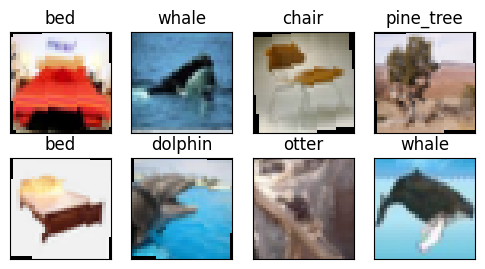

In [9]:
#Observe the dataset
print("Visualization of a sample of the dataset :")
show_img(trainset,train_data, random = True)

Visualization of random transformation on an image


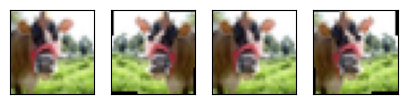

In [10]:
#Observe random transformation :
print("Visualization of random transformation on an image")
transform_visualisation(train_data)

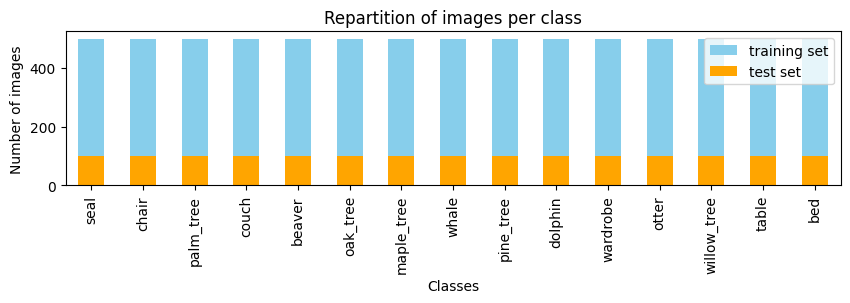

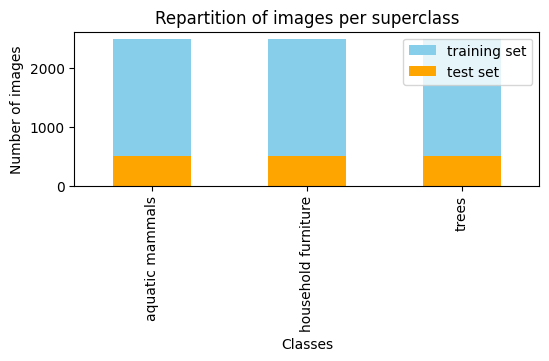

In [11]:
#Histogram repartion per class
plt.figure(figsize=(10, 2))
histogram_data_df("class",train_df,test_df)
#Histogram repartition per superclass
plt.figure(figsize=(6, 2))
histogram_data_df("superclass",train_df,test_df)

# 2. Training models :

## A. Classification in super-classes :

In [12]:
#Add some functions to move to GPU
#Move from CPU to GPU
def check_device():
    if torch.cuda.is_available:
        return torch.device('cuda')
    else:
        return torch.device('cpu')

# Function to transfer from CPU to GPU
def move_device(tensor, device):

    # Move all individual tensors from cpu to gpu
    if isinstance(tensor, (list,tuple)):
        return [move_device(element, device) for element in tensor]
    return tensor.to(device, non_blocking=True)

# Execute transfer from CPU to GPU for each device
class DeviceDataLoader():

    # Define Constructor
    def __init__(self, dataloader, device):
        self.dl = dataloader
        self.device = device

    def __iter__(self):

       # Transfer each batch and return
        for i in self.dl:
            yield move_device(i, self.device)

    def __len__(self):

        # Return the number of batches
        return len(self.dl)

device = check_device() #Assign device of GPU

### a. Define models :

In [13]:
#Model create layer by layer
class convnet_no_dropout(nn.Module):
    # Constructor
    def __init__(self,nb_class):
        super(convnet_no_dropout, self).__init__()
        '''
         Convolutional layers
         Conv2d (input channels, output channels, kernel_size, padding)
        '''
        self.nb_class = nb_class

        self.conv_layer_1 = torch.nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16,kernel_size= 3,stride=1, padding=1),
            nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2)
        )

        self.conv_layer_2 = torch.nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32,kernel_size= 3,stride=1, padding=1),
            nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2)
        )


        self.conv_layer_3 = torch.nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64,kernel_size= 3,stride=1, padding=1),
            nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2)
        )
        self.conv_layer_4 = torch.nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128,kernel_size= 3,stride=1, padding=1),
            nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2)
        )


        # Fully Connected layers
        self.hidden_layer = nn.Linear(128*2*2, 206)
        self.output_layer = nn.Linear(206, self.nb_class)

        #Dropout to avoid over-fitting :
        self.dropout_layer = nn.Dropout(p=0.5)

    def forward(self, ip):

        # Calling all the convolutional layers
        output = self.conv_layer_1(ip)
        output = self.conv_layer_2(output)
        output = self.conv_layer_3(output)
        output = self.conv_layer_4(output)

        # Flattening
        output = output.view(-1, 128*2*2)

        # Call fully connected layer
        output = self.hidden_layer(output)
        #adding dropout to avoid over-fitting
        output = self.dropout_layer(output)


        output=self.output_layer(output)

        return output


## B. Training:




In [39]:
def convert_labels(labels,eq_df,old_label,new_label,GPU=False):
  labels_list = labels.tolist()
  #new_labels = [label for label in labels_list]

  new_labels = [eq_df[eq_df[old_label]== label_nb][new_label].values[0] for label_nb in labels_list]
  new_labels_tensor = torch.tensor(new_labels)
  if GPU:
    new_labels_tensor = move_device(new_labels_tensor, device)
  return new_labels_tensor

def accuracy(outputs, labels, GPU='False'):
    _, preds = torch.max(outputs, dim=1)
    acc = torch.tensor(torch.sum(preds == labels).item()/len(preds))
    if GPU:
      acc = move_device(acc, device)
    return acc

def accuracy_B(outputs, labels,GPU="False"):
    _, preds = torch.max(outputs, dim=1)
    #convert label to superclasses
    preds_B = convert_labels(preds,eq_df,old_label = "label_B",new_label = "label_A") # Convert from label at the class, and label at the superclass.
    labels_B = convert_labels(labels,eq_df,old_label = "label_B",new_label = "label_A")
    acc = torch.tensor(torch.sum(preds_B == labels_B).item()/len(preds))
    if GPU:
      acc = move_device(acc, device)
    return acc

def evaluate(model,valid_dl,loss_func,mode = "A"):
    model.eval()
    batch_losses, batch_accs=[],[]
    for images,labels in valid_dl:
        labels = convert_labels(labels,eq_df,old_label = "label",new_label = f"label_{mode}",GPU= GPU)
        predicted=model(images)
        batch_losses.append(loss_func(predicted,labels))
        if mode == "A":
          batch_accs.append(accuracy(predicted,labels,GPU = GPU))
        elif mode == "B":
          batch_accs.append(accuracy_B(predicted,labels, GPU = GPU))
    epoch_avg_loss=torch.stack(batch_losses).mean().item()# To keep only the mean
    epoch_avg_acc=torch.stack(batch_accs).mean().item()
    return epoch_avg_loss,epoch_avg_acc

def train(model,train_dl,valid_dl,epochs, max_lr, loss_func,optim,eq_df,mode="A", scheduler_lr = "True"):

    #Choice of the optimization function, Weight decay is associated to L2 Norm
    if optim == "Adam":
      optimizer = torch.optim.Adam(model.parameters(), max_lr,weight_decay=1e-5)
    elif optim == "SGD":
      optimizer= torch.optim.SGD(model.parameters(), max_lr,weight_decay=1e-4)
    elif optim == "Momentum":
      optimizer=torch.optim.SGD(model.parameters(), max_lr,momentum=0.9,weight_decay=1e-4)

    #Adding a learning rate scheduler
    if scheduler_lr :
      scheduler=torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr,epochs*len(train_dl)) #Allow a moving lr, best for fast convergence.


    results=[]
    best_epoch, best_epoch_nb = -1,-1 #To save the best epoch weight.
    #using tqdm for the bouclz over epoch

    for epoch in tqdm(range(1,epochs+1),desc="training in progress"):
    #for epoch in range(1,epochs+1):
        model.train()
        train_losses, train_batch_accs, lrs =[],[],[]

        #Compute over a minibatch
        for images, labels in train_dl:
          labels = convert_labels(labels,eq_df,old_label = "label",new_label = f"label_{mode}",GPU=GPU) # Adapt to the classes (Option A or B)
          optimizer.zero_grad() #Gradient set to zero to avoid accumulation during training (Backprog at the scale of mini-batch not over all the dataset)
          predicted=model(images)
          loss=loss_func(predicted,labels)
          train_losses.append(loss)
          loss.backward() #Compute backpropagation
          optimizer.step() # Update weights

          # keep track of learning rate and metrics (here as the dataset is balanced, accuracy alone is relevant)
          if mode == "A":
            train_batch_accs.append(accuracy(predicted,labels,GPU=GPU))
          elif mode == "B":
            train_batch_accs.append(accuracy_B(predicted,labels,GPU=GPU)) #For Option B, the classification is made on classes, but the accuracy compute according superclasses.
          lrs.append(optimizer.param_groups[0]['lr'])
          if scheduler_lr :
            scheduler.step() #Update learning rate


        epoch_train_acc=torch.stack(train_batch_accs).mean().item()
        epoch_train_loss=torch.stack(train_losses).mean().item()
        epoch_avg_loss,epoch_avg_acc=evaluate(model,valid_dl,loss_func,mode=mode) #having the avg metrics for the epoch.

        results.append({'avg_valid_loss': epoch_avg_loss,
                        'avg_val_acc': epoch_avg_acc,
                        'avg_train_loss':epoch_train_loss,
                        'avg_train_acc':epoch_train_acc,
                        'lrs':lrs})

        print('Number of epochs:', epoch,'|',
              'Validation loss :',epoch_avg_loss, ' |','Training loss :'
              ,epoch_train_loss,' |  '
              ,'Training accuracy:', epoch_train_acc
              , 'validation accuracy :',epoch_avg_acc)
        #Save the best model
        if best_epoch == -1 or epoch_avg_acc > best_epoch:
          best_epoch = epoch_avg_acc
          torch.save(model.state_dict(), f'model_{mode}_optim_{optim}_epoch_{epoch}_weights.pth')
          #remove old weight
          if best_epoch_nb != -1:
            os.remove(f'model_{mode}_optim_{optim}_epoch_{best_epoch_nb}_weights.pth')

          best_epoch_nb = epoch
        #Save the last epoch weight
        torch.save(model.state_dict(), f'model_{mode}_optim_{optim}_best_epoch_weights.pth')
    #Save the last epoch weight
    torch.save(model.state_dict(), f'model_{mode}_optim_{optim}_epoch_{epoch}_weights.pth')

    return results

def set_model(MODEL,MODE, SUPER_CLASSES,train_df,GPU = False,FROM_CKP=False,CKP_PATH = None):
  if MODE == "A":
    nb_class = len(SUPER_CLASSES)
  elif MODE == "B":
    nb_class = len(train_df["class"].unique())

  if MODEL == "conv":
    model = convnet_no_dropout(nb_class = nb_class)
  elif MODEL =="eff":
    weights_eff = torchvision.models.EfficientNet_V2_S_Weights.IMAGENET1K_V1
    model = torchvision.models.efficientnet_v2_s(weights=weights_eff)
    model.classifier[1] = nn.Linear(1280, nb_class)
  if FROM_CKP:
    model.load_state_dict(torch.load(CKP_PATH))
  if GPU :
    model = move_device(model, device)
  return model

#Visualization:
def plot_metric(train_metric,test_metric,label,option_label = "",color = "orange"):
  plt.title(f"{label} per epoch")
  plt.plot(epoch_count,train_metric,label=f"Training {label} {option_label}",linewidth = '1',color = color)
  plt.plot(epoch_count,test_metric,"--",label=f"Test {label} {option_label}",linewidth = '1',color = color)
  plt.xlabel('Epoch')
  plt.ylabel(f'{label} per epoch')
  plt.legend()
def plot_all_metrics(tr_acc,ts_acc,tr_loss,ts_loss,lr,epoch_count,label,color="orange"):
  #Visualize metrics over epochs

  plt.subplot(1,3,1)
  plot_metric(tr_loss,ts_loss,"Loss",option_label = label,color = color)
  plt.subplot(1,3,2)
  plot_metric(tr_acc,ts_acc,"Accuracy",option_label = label, color =color)

  #Visualize lr evolution
  plt.subplot(1,3,3)
  epoch = np.linspace(1,EPOCHS,len(lr))
  plt.plot(epoch,lr)
  plt.title("learning_rate over epochs")
  plt.xlabel('Epoch')
  plt.ylabel('Learning rate')

#Test functions.
def test_accuracy(mode = "A"):
  if mode == "A" :
    preds = [[0.3,-0.1,-0.1],[0.3,0.1,-0.1],[-0.3,0.1,-0.1]]
    labels = [0,1,1]
  else :
    preds = [[0,0,0,0.6,0,0,0.5,0,0,0,0,0.2,0,0,0],[0,0.7,0,0.6,0,0,0.5,0,0,0,0,0.2,0,0,0],[0,0,0,0.6,0,0,0.5,0,0,0,0.8,0.2,0,0,0]] # 4,2, 11
  preds = torch.tensor(preds)
  labels = torch.tensor(labels)
  if mode == "A":
    acc = accuracy(preds,labels)
  else :
    acc = accuracy_B(preds,labels)
  return acc


In [46]:
#TRAINING Options
#Parameters
OPTION = "A" #A (Classification per superclass) or B (Classification per class and accuracy per superclass)
MODEL = "conv" #"conv" for classic CNN network pretty simple, or "eff" to use EfficientNetV2 pre-trained.
EPOCHS = 30
BATCH_SIZE = 64

MAX_LR = 1e-3 #Best 1e-1/2 with scheduler or 1e-4 without
SCHEDULER = True
optim = "Adam" #Adam, SGD or Momentum

FROM_CKP = False #If loading from another model.
CKP_PATH = ""

#Loss
loss_func=nn.functional.cross_entropy # example : nn.functional.cross_entropy

#creating dataloader (for minibatch generation)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

#model resume
model = set_model(MODEL,OPTION,SUPER_CLASSES,train_df,GPU=GPU)
summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
         MaxPool2d-3           [-1, 16, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]           4,640
              ReLU-5           [-1, 32, 16, 16]               0
         MaxPool2d-6             [-1, 32, 8, 8]               0
            Conv2d-7             [-1, 64, 8, 8]          18,496
              ReLU-8             [-1, 64, 8, 8]               0
         MaxPool2d-9             [-1, 64, 4, 4]               0
           Conv2d-10            [-1, 128, 4, 4]          73,856
             ReLU-11            [-1, 128, 4, 4]               0
        MaxPool2d-12            [-1, 128, 2, 2]               0
           Linear-13                  [-1, 206]         105,678
          Dropout-14                  [

In [47]:
# Move all the tensors to GPU
if GPU:
  trainloader = DeviceDataLoader(trainloader, device)
  testloader = DeviceDataLoader(testloader, device)

#Training
OPTION = "A"
model = set_model(MODEL,OPTION,SUPER_CLASSES,train_df,GPU=GPU)
results_A = train(model,trainloader,testloader,EPOCHS, MAX_LR, loss_func,optim,eq_df,mode=OPTION, scheduler_lr = SCHEDULER)
OPTION = "B"
model = set_model(MODEL,OPTION,SUPER_CLASSES,train_df,GPU=GPU)
results_B = train(model,trainloader,testloader,EPOCHS, MAX_LR, loss_func,optim,eq_df,mode=OPTION, scheduler_lr = SCHEDULER)



training in progress:   3%|▎         | 1/30 [00:06<02:58,  6.17s/it]

Number of epochs: 1 | Validation loss : 0.9581658840179443  | Training loss : 1.0635976791381836  |   Training accuracy: 0.4306585490703583 validation accuracy : 0.5594308376312256


training in progress:   7%|▋         | 2/30 [00:12<03:01,  6.47s/it]

Number of epochs: 2 | Validation loss : 0.725639283657074  | Training loss : 0.8120306134223938  |   Training accuracy: 0.6360345482826233 validation accuracy : 0.705450177192688


training in progress:  10%|█         | 3/30 [00:18<02:50,  6.31s/it]

Number of epochs: 3 | Validation loss : 0.5522382855415344  | Training loss : 0.6397268772125244  |   Training accuracy: 0.7320798635482788 validation accuracy : 0.789620578289032


training in progress:  13%|█▎        | 4/30 [00:25<02:47,  6.43s/it]

Number of epochs: 4 | Validation loss : 0.6025784015655518  | Training loss : 0.5523772239685059  |   Training accuracy: 0.7757326364517212 validation accuracy : 0.7518601417541504


training in progress:  17%|█▋        | 5/30 [00:31<02:37,  6.31s/it]

Number of epochs: 5 | Validation loss : 0.5114922523498535  | Training loss : 0.5033186674118042  |   Training accuracy: 0.8029661178588867 validation accuracy : 0.7941778898239136


training in progress:  20%|██        | 6/30 [00:38<02:33,  6.41s/it]

Number of epochs: 6 | Validation loss : 0.5157557129859924  | Training loss : 0.45488080382347107  |   Training accuracy: 0.8220779895782471 validation accuracy : 0.7824591398239136


training in progress:  23%|██▎       | 7/30 [00:44<02:25,  6.32s/it]

Number of epochs: 7 | Validation loss : 0.4182608127593994  | Training loss : 0.42098894715309143  |   Training accuracy: 0.8366879224777222 validation accuracy : 0.8356584906578064


training in progress:  27%|██▋       | 8/30 [00:51<02:22,  6.48s/it]

Number of epochs: 8 | Validation loss : 0.4482942521572113  | Training loss : 0.4008440375328064  |   Training accuracy: 0.844412088394165 validation accuracy : 0.822265625


training in progress:  30%|███       | 9/30 [00:57<02:14,  6.42s/it]

Number of epochs: 9 | Validation loss : 0.41147857904434204  | Training loss : 0.3645525872707367  |   Training accuracy: 0.8609198927879333 validation accuracy : 0.8386346697807312


training in progress:  33%|███▎      | 10/30 [01:04<02:09,  6.50s/it]

Number of epochs: 10 | Validation loss : 0.35892510414123535  | Training loss : 0.34553906321525574  |   Training accuracy: 0.8691296577453613 validation accuracy : 0.8575148582458496


training in progress:  37%|███▋      | 11/30 [01:10<02:03,  6.51s/it]

Number of epochs: 11 | Validation loss : 0.34411388635635376  | Training loss : 0.3074241876602173  |   Training accuracy: 0.8810470104217529 validation accuracy : 0.8620721697807312


training in progress:  40%|████      | 12/30 [01:17<01:56,  6.48s/it]

Number of epochs: 12 | Validation loss : 0.33887404203414917  | Training loss : 0.2874669134616852  |   Training accuracy: 0.8926995396614075 validation accuracy : 0.870256781578064


training in progress:  43%|████▎     | 13/30 [01:24<01:52,  6.62s/it]

Number of epochs: 13 | Validation loss : 0.3172453045845032  | Training loss : 0.26508116722106934  |   Training accuracy: 0.8994085192680359 validation accuracy : 0.8821614980697632


training in progress:  47%|████▋     | 14/30 [01:30<01:43,  6.47s/it]

Number of epochs: 14 | Validation loss : 0.31424278020858765  | Training loss : 0.2408715933561325  |   Training accuracy: 0.9067796468734741 validation accuracy : 0.8841146230697632


training in progress:  50%|█████     | 15/30 [01:37<01:38,  6.58s/it]

Number of epochs: 15 | Validation loss : 0.3570612370967865  | Training loss : 0.2251884937286377  |   Training accuracy: 0.9126942753791809 validation accuracy : 0.8669084906578064


training in progress:  53%|█████▎    | 16/30 [01:43<01:30,  6.49s/it]

Number of epochs: 16 | Validation loss : 0.32370078563690186  | Training loss : 0.21688354015350342  |   Training accuracy: 0.9163576364517212 validation accuracy : 0.8739769458770752


training in progress:  57%|█████▋    | 17/30 [01:50<01:26,  6.63s/it]

Number of epochs: 17 | Validation loss : 0.2794401943683624  | Training loss : 0.19277818500995636  |   Training accuracy: 0.9271275401115417 validation accuracy : 0.9011346697807312


training in progress:  60%|██████    | 18/30 [01:56<01:17,  6.49s/it]

Number of epochs: 18 | Validation loss : 0.3476654291152954  | Training loss : 0.16798147559165955  |   Training accuracy: 0.9377648234367371 validation accuracy : 0.881975531578064


training in progress:  63%|██████▎   | 19/30 [02:03<01:13,  6.65s/it]

Number of epochs: 19 | Validation loss : 0.30315345525741577  | Training loss : 0.16327719390392303  |   Training accuracy: 0.9369262456893921 validation accuracy : 0.8937872648239136


training in progress:  67%|██████▋   | 20/30 [02:09<01:05,  6.51s/it]

Number of epochs: 20 | Validation loss : 0.27733612060546875  | Training loss : 0.1501985639333725  |   Training accuracy: 0.9453125 validation accuracy : 0.9004836082458496


training in progress:  70%|███████   | 21/30 [02:16<00:59,  6.61s/it]

Number of epochs: 21 | Validation loss : 0.3171229958534241  | Training loss : 0.11705434322357178  |   Training accuracy: 0.9593484997749329 validation accuracy : 0.9017857313156128


training in progress:  73%|███████▎  | 22/30 [02:23<00:52,  6.59s/it]

Number of epochs: 22 | Validation loss : 0.2880370020866394  | Training loss : 0.11571843922138214  |   Training accuracy: 0.9582450985908508 validation accuracy : 0.9056919813156128


training in progress:  77%|███████▋  | 23/30 [02:29<00:46,  6.62s/it]

Number of epochs: 23 | Validation loss : 0.28282544016838074  | Training loss : 0.10151583701372147  |   Training accuracy: 0.9655720591545105 validation accuracy : 0.9079241156578064


training in progress:  80%|████████  | 24/30 [02:36<00:40,  6.70s/it]

Number of epochs: 24 | Validation loss : 0.27769893407821655  | Training loss : 0.09066223353147507  |   Training accuracy: 0.9716631174087524 validation accuracy : 0.9113653898239136


training in progress:  83%|████████▎ | 25/30 [02:42<00:32,  6.57s/it]

Number of epochs: 25 | Validation loss : 0.27652621269226074  | Training loss : 0.07823402434587479  |   Training accuracy: 0.9735169410705566 validation accuracy : 0.9120163917541504


training in progress:  87%|████████▋ | 26/30 [02:49<00:26,  6.69s/it]

Number of epochs: 26 | Validation loss : 0.29499563574790955  | Training loss : 0.06939295679330826  |   Training accuracy: 0.9773569703102112 validation accuracy : 0.908761203289032


training in progress:  90%|█████████ | 27/30 [02:56<00:19,  6.60s/it]

Number of epochs: 27 | Validation loss : 0.2789003252983093  | Training loss : 0.0697949156165123  |   Training accuracy: 0.9766508340835571 validation accuracy : 0.914620578289032


training in progress:  93%|█████████▎| 28/30 [03:03<00:13,  6.76s/it]

Number of epochs: 28 | Validation loss : 0.2823670506477356  | Training loss : 0.06295956671237946  |   Training accuracy: 0.9798287749290466 validation accuracy : 0.9098772406578064


training in progress:  97%|█████████▋| 29/30 [03:09<00:06,  6.61s/it]

Number of epochs: 29 | Validation loss : 0.2831610441207886  | Training loss : 0.06431928277015686  |   Training accuracy: 0.9790784120559692 validation accuracy : 0.908575177192688


training in progress: 100%|██████████| 30/30 [03:16<00:00,  6.55s/it]


Number of epochs: 30 | Validation loss : 0.2833988070487976  | Training loss : 0.059942618012428284  |   Training accuracy: 0.9804025292396545 validation accuracy : 0.9092261791229248


training in progress:   3%|▎         | 1/30 [00:11<05:45, 11.91s/it]

Number of epochs: 1 | Validation loss : 2.680750608444214  | Training loss : 2.70174241065979  |   Training accuracy: 0.35257768630981445 validation accuracy : 0.3444940447807312


training in progress:   7%|▋         | 2/30 [00:23<05:35, 11.96s/it]

Number of epochs: 2 | Validation loss : 2.2991225719451904  | Training loss : 2.5595295429229736  |   Training accuracy: 0.4722369313240051 validation accuracy : 0.6241629719734192


training in progress:  10%|█         | 3/30 [00:35<05:21, 11.89s/it]

Number of epochs: 3 | Validation loss : 1.9960435628890991  | Training loss : 2.1549935340881348  |   Training accuracy: 0.6571769118309021 validation accuracy : 0.7225632667541504


training in progress:  13%|█▎        | 4/30 [00:47<05:10, 11.93s/it]

Number of epochs: 4 | Validation loss : 1.849225401878357  | Training loss : 1.9750237464904785  |   Training accuracy: 0.7337570190429688 validation accuracy : 0.7637648582458496


training in progress:  17%|█▋        | 5/30 [00:59<04:56, 11.86s/it]

Number of epochs: 5 | Validation loss : 1.771136999130249  | Training loss : 1.85574471950531  |   Training accuracy: 0.7658014893531799 validation accuracy : 0.7984561324119568


training in progress:  20%|██        | 6/30 [01:11<04:43, 11.83s/it]

Number of epochs: 6 | Validation loss : 1.701064944267273  | Training loss : 1.7799971103668213  |   Training accuracy: 0.7841190695762634 validation accuracy : 0.803850531578064


training in progress:  23%|██▎       | 7/30 [01:22<04:31, 11.81s/it]

Number of epochs: 7 | Validation loss : 1.617677927017212  | Training loss : 1.6625945568084717  |   Training accuracy: 0.8075123429298401 validation accuracy : 0.7992932200431824


training in progress:  27%|██▋       | 8/30 [01:34<04:19, 11.81s/it]

Number of epochs: 8 | Validation loss : 1.584763526916504  | Training loss : 1.6033470630645752  |   Training accuracy: 0.8152366280555725 validation accuracy : 0.8324963450431824


training in progress:  30%|███       | 9/30 [01:46<04:09, 11.86s/it]

Number of epochs: 9 | Validation loss : 1.5102180242538452  | Training loss : 1.5314580202102661  |   Training accuracy: 0.8315237164497375 validation accuracy : 0.8513765335083008


training in progress:  33%|███▎      | 10/30 [01:58<03:57, 11.87s/it]

Number of epochs: 10 | Validation loss : 1.514095664024353  | Training loss : 1.4830182790756226  |   Training accuracy: 0.8446328043937683 validation accuracy : 0.8364025950431824


training in progress:  37%|███▋      | 11/30 [02:10<03:46, 11.93s/it]

Number of epochs: 11 | Validation loss : 1.4366912841796875  | Training loss : 1.4096909761428833  |   Training accuracy: 0.8575652837753296 validation accuracy : 0.8474702835083008


training in progress:  40%|████      | 12/30 [02:22<03:35, 11.95s/it]

Number of epochs: 12 | Validation loss : 1.439092993736267  | Training loss : 1.3504881858825684  |   Training accuracy: 0.8689972162246704 validation accuracy : 0.8361234664916992


training in progress:  43%|████▎     | 13/30 [02:34<03:22, 11.94s/it]

Number of epochs: 13 | Validation loss : 1.3817328214645386  | Training loss : 1.2947405576705933  |   Training accuracy: 0.8810911178588867 validation accuracy : 0.868303656578064


training in progress:  47%|████▋     | 14/30 [02:46<03:11, 11.95s/it]

Number of epochs: 14 | Validation loss : 1.3622101545333862  | Training loss : 1.2326427698135376  |   Training accuracy: 0.8899188041687012 validation accuracy : 0.869512677192688


training in progress:  50%|█████     | 15/30 [02:58<02:58, 11.87s/it]

Number of epochs: 15 | Validation loss : 1.3235654830932617  | Training loss : 1.1947370767593384  |   Training accuracy: 0.8957892060279846 validation accuracy : 0.8693265914916992


training in progress:  53%|█████▎    | 16/30 [03:09<02:45, 11.82s/it]

Number of epochs: 16 | Validation loss : 1.2741254568099976  | Training loss : 1.1322619915008545  |   Training accuracy: 0.9049699306488037 validation accuracy : 0.8787202835083008


training in progress:  57%|█████▋    | 17/30 [03:21<02:33, 11.80s/it]

Number of epochs: 17 | Validation loss : 1.2711293697357178  | Training loss : 1.0966339111328125  |   Training accuracy: 0.9153425693511963 validation accuracy : 0.8883928656578064


training in progress:  60%|██████    | 18/30 [03:33<02:22, 11.86s/it]

Number of epochs: 18 | Validation loss : 1.2642936706542969  | Training loss : 1.0381218194961548  |   Training accuracy: 0.9186529517173767 validation accuracy : 0.8921130895614624


training in progress:  63%|██████▎   | 19/30 [03:45<02:11, 11.93s/it]

Number of epochs: 19 | Validation loss : 1.2259128093719482  | Training loss : 1.0223912000656128  |   Training accuracy: 0.9215218424797058 validation accuracy : 0.8918341398239136


training in progress:  67%|██████▋   | 20/30 [03:57<01:58, 11.83s/it]

Number of epochs: 20 | Validation loss : 1.2372889518737793  | Training loss : 0.9615628123283386  |   Training accuracy: 0.9316737055778503 validation accuracy : 0.8936011791229248


training in progress:  70%|███████   | 21/30 [04:09<01:46, 11.82s/it]

Number of epochs: 21 | Validation loss : 1.204429030418396  | Training loss : 0.9084219932556152  |   Training accuracy: 0.9360434412956238 validation accuracy : 0.898995578289032


training in progress:  73%|███████▎  | 22/30 [04:20<01:34, 11.78s/it]

Number of epochs: 22 | Validation loss : 1.2109894752502441  | Training loss : 0.8743668794631958  |   Training accuracy: 0.9423552751541138 validation accuracy : 0.8976935148239136


training in progress:  77%|███████▋  | 23/30 [04:32<01:22, 11.79s/it]

Number of epochs: 23 | Validation loss : 1.2218939065933228  | Training loss : 0.8486137390136719  |   Training accuracy: 0.9455773234367371 validation accuracy : 0.8965773582458496


training in progress:  80%|████████  | 24/30 [04:44<01:11, 11.85s/it]

Number of epochs: 24 | Validation loss : 1.2132933139801025  | Training loss : 0.8219302296638489  |   Training accuracy: 0.9494173526763916 validation accuracy : 0.893136203289032


training in progress:  83%|████████▎ | 25/30 [04:56<00:59, 11.91s/it]

Number of epochs: 25 | Validation loss : 1.2180824279785156  | Training loss : 0.7809813618659973  |   Training accuracy: 0.9521539807319641 validation accuracy : 0.8978794813156128


training in progress:  87%|████████▋ | 26/30 [05:08<00:47, 11.83s/it]

Number of epochs: 26 | Validation loss : 1.2009639739990234  | Training loss : 0.7579649686813354  |   Training accuracy: 0.9557291865348816 validation accuracy : 0.9015997648239136


training in progress:  90%|█████████ | 27/30 [05:20<00:35, 11.80s/it]

Number of epochs: 27 | Validation loss : 1.2046350240707397  | Training loss : 0.7459195256233215  |   Training accuracy: 0.9560381174087524 validation accuracy : 0.9011346697807312


training in progress:  93%|█████████▎| 28/30 [05:31<00:23, 11.80s/it]

Number of epochs: 28 | Validation loss : 1.207000494003296  | Training loss : 0.731359601020813  |   Training accuracy: 0.9557291865348816 validation accuracy : 0.9004836082458496


training in progress:  97%|█████████▋| 29/30 [05:43<00:11, 11.76s/it]

Number of epochs: 29 | Validation loss : 1.2064464092254639  | Training loss : 0.7302024960517883  |   Training accuracy: 0.9584656953811646 validation accuracy : 0.9024367332458496


training in progress: 100%|██████████| 30/30 [05:55<00:00, 11.84s/it]

Number of epochs: 30 | Validation loss : 1.206630825996399  | Training loss : 0.7195729613304138  |   Training accuracy: 0.960496187210083 validation accuracy : 0.9017857313156128


In [48]:
#Getting Metrics
def getting_metrics(results,EPOCHS):
  avg_training_accuracy, avg_validation_accuracy =[], []
  avg_training_loss, avg_validation_loss=[],[]
  lr = []
  for result in results:
      avg_training_accuracy.append(result['avg_train_acc'])
      avg_validation_accuracy.append(result['avg_val_acc'])
      avg_validation_loss.append(result['avg_valid_loss'])
      avg_training_loss.append(result['avg_train_loss'])
      lr = np.concatenate((lr,result['lrs']))
  epoch_count=[]
  for i in range(1,EPOCHS+1):
      epoch_count.append(i)
  return avg_training_accuracy, avg_validation_accuracy, avg_training_loss, avg_validation_loss, lr, epoch_count

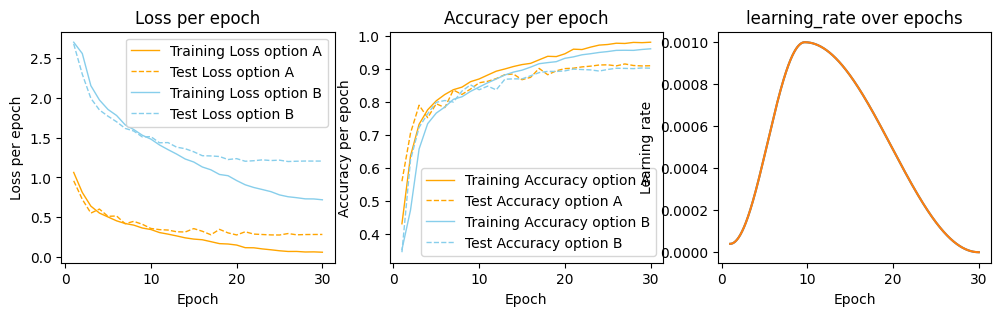

In [49]:

plt.figure(figsize=(12,3))
tr_acc,ts_acc,tr_loss,ts_loss,lr,epoch_count = getting_metrics(results_A,EPOCHS)
plot_all_metrics(tr_acc,ts_acc,tr_loss,ts_loss,lr,epoch_count,"option A")

tr_acc,ts_acc,tr_loss,ts_loss,lr,epoch_count = getting_metrics(results_B,EPOCHS)
plot_all_metrics(tr_acc,ts_acc,tr_loss,ts_loss,lr,epoch_count,"option B",color="skyblue")




#. Evaluate models:

In [86]:
#Functions :
def predict_img(img,model,mode = "A",GPU="false"):
  model.eval()
  img = img.unsqueeze(0)
  if GPU:
    img = move_device(img, device)
  yb = model(img)
  _, pred = torch.max(yb, dim=1)
  if mode == "A":
    pred = pred.item()
  elif mode == "B":
    pred = convert_labels(pred,eq_df,old_label="label_B",new_label="label_A",GPU = GPU)
    pred = pred.item()
  return pred

def predict_and_show(img,label,model,mode = "A",GPU = "False"):
  pred = predict_img(img,model,mode=mode,GPU=GPU)
  #Getting Super Class name from ground truth and prediction
  pred_sc = eq_df[eq_df[f"label_{mode}"]==pred]["superclass"].values[0]
  label_sc = eq_df[eq_df["label"]==label]["superclass"].values[0]
  if GPU:
    img = img.cpu()
  img=img*0.5 +0.5 #Denormalize the img
  plt.imshow(img.permute(1, 2, 0))
  plt.title(f"gt: {label_sc}, pred :{pred_sc} ")
  return pred

In [88]:
#On charge les poids du modèle.
OPTION_eval = "A"
PATH_CKP = '/content/model_A_optim_Adam_best_epoch_weights.pth'

if MODEL == "conv":
  model_eval = convnet_no_dropout(nb_class=nb_class)

if MODEL == "eff":
  weights_eff = torchvision.models.EfficientNet_V2_S_Weights.IMAGENET1K_V1
  model_eval = torchvision.models.efficientnet_v2_s(weights=weights_eff)
  model_eval.classifier[1] = nn.Linear(1280, len(SUPER_CLASSES))

if GPU:
  model_eval = move_device(model_eval, device)


model_eval.load_state_dict(torch.load(PATH_CKP))

<All keys matched successfully>

In [89]:
#Eval the model on the test dataset (Metrics + Confusion Matrix)
model_eval.eval()
batch_losses, batch_accs=[],[]
all_predictions, all_labels = [], []  # Pour la matrice de confusion
i=0

for images,labels in testloader:
  labels = convert_labels(labels,eq_df,old_label="label",new_label=f"label_{OPTION_eval}",GPU=GPU)
  predicted=model_eval(images)
  batch_losses.append(loss_func(predicted,labels))
  if OPTION_eval == "A":
    batch_accs.append(accuracy(predicted,labels))
  elif OPTION_eval == "B":
    batch_accs.append(accuracy_B(predicted,labels))

  # Collecter pour matrice de confusion
  _, preds = torch.max(predicted, 1)  # Classes prédites
  if OPTION_eval =="B":
    preds = convert_labels(preds,eq_df,old_label="label_B",new_label="label_A",GPU=GPU)
    labels = convert_labels(labels,eq_df,old_label="label_B",new_label="label_A",GPU=GPU)
  all_predictions.extend(preds.cpu().numpy())#all_predictions.extend(preds.cpu().numpy())
  all_labels.extend(labels.cpu().numpy()) #   all_labels.extend(labels.cpu().numpy())

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       500
           1       0.88      0.92      0.90       500
           2       0.95      0.90      0.92       500

    accuracy                           0.90      1500
   macro avg       0.91      0.90      0.90      1500
weighted avg       0.91      0.90      0.90      1500



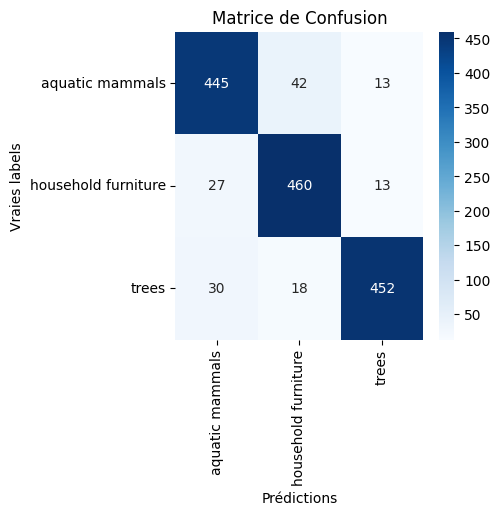

In [90]:
from sklearn.metrics import confusion_matrix, classification_report
# Créer la matrice de confusion
cm = confusion_matrix(all_labels, all_predictions)
print(classification_report(all_labels, all_predictions))

# Plot de la matrice de confusion
class_names = SUPER_CLASSES
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',xticklabels=class_names,yticklabels=class_names)
plt.title('Matrice de Confusion')
plt.ylabel('Vraies labels')
plt.xlabel('Prédictions')
plt.show()

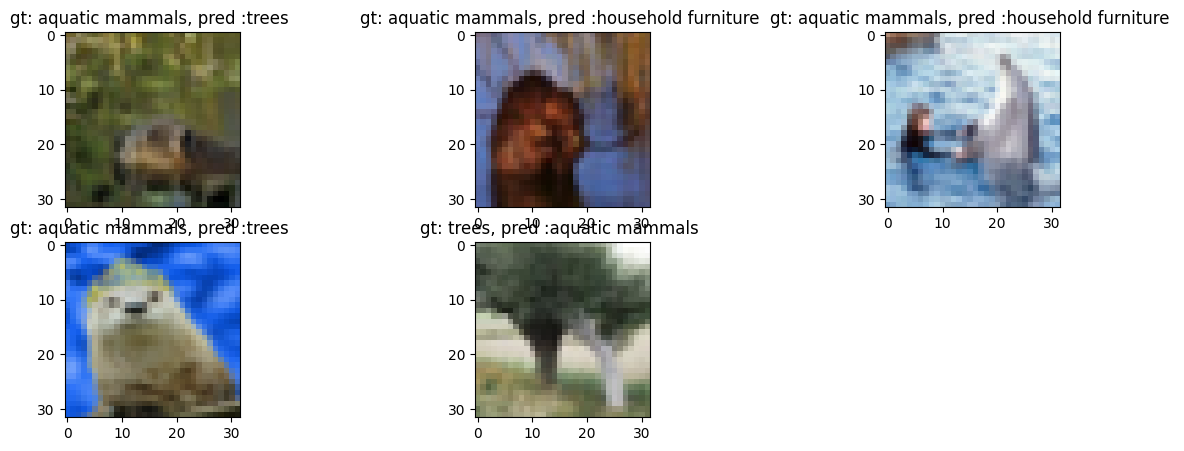

In [91]:
#List all wrong predictions
check_predict = np.equal(all_predictions,all_labels)
idx_false = np.where(check_predict == False)[0]

plt.figure(figsize=(15,5))
for i in range(5):

  #Observe some wrong predictions.
  idx_wrong = np.random.choice(idx_false)
  img,label = testset[idx_wrong]
  if GPU:
    img = move_device(img, device)
  plt.subplot(2,3,i+1)
  pred = predict_and_show(img,label,model_eval,GPU=GPU)